In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [2]:
file_path = "../data/raw/online_retail.csv"
raw_data = pd.read_csv(file_path, encoding="ISO-8859-1")

data= raw_data.copy()

In [3]:
data = data[~data['InvoiceNo'].str.startswith('C')]

In [4]:
data = data[data['Quantity'] > 0]

In [5]:
data = data[data['UnitPrice'] >  0]

In [6]:
data = data.dropna(subset=['CustomerID'])
data['CustomerID'] = data['CustomerID'].astype(int)

In [7]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [8]:
customers = (
    data[['CustomerID', 'Country']].drop_duplicates()
)

In [9]:
products = (
    data[['StockCode', 'Description', 'UnitPrice']].drop_duplicates()
)

In [10]:
orders = (
    data[['InvoiceNo', 'InvoiceDate', 'CustomerID', 'Country']].drop_duplicates(subset=['InvoiceDate'])
)

In [11]:
conn = sqlite3.connect("../retail.db")

customers.to_sql("customers", conn, if_exists="replace", index=False)
products.to_sql("products", conn, if_exists="replace", index=False)
orders.to_sql("orders", conn, if_exists="replace", index=False)
data.to_sql("data", conn, if_exists="replace", index=False)

397884

In [12]:
conn.execute('DROP TABLE IF EXISTS order_items;')
conn.commit()

In [13]:
#Preview customers
pd.read_sql("SELECT * FROM customers LIMIT 5;", conn)

,CustomerID,Country
0,17850,United Kingdom
1,13047,United Kingdom
2,12583,France
3,13748,United Kingdom
4,15100,United Kingdom


In [14]:
# Preview products
pd.read_sql("SELECT * FROM products LIMIT 5;", conn)

,StockCode,Description,UnitPrice
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55
1,71053,WHITE METAL LANTERN,3.39
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39


In [15]:
# Preview orders
pd.read_sql("SELECT * FROM orders LIMIT 5;", conn)

,InvoiceNo,InvoiceDate,CustomerID,Country
0,536365,2010-12-01 08:26:00,17850,United Kingdom
1,536366,2010-12-01 08:28:00,17850,United Kingdom
2,536367,2010-12-01 08:34:00,13047,United Kingdom
3,536369,2010-12-01 08:35:00,13047,United Kingdom
4,536370,2010-12-01 08:45:00,12583,France


In [16]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,fact_orders
1,sqlite_sequence
2,dim_customers
3,dim_products
4,dim_date
5,customers
6,products
7,orders
8,data


In [17]:
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

order_items = (
    data[['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice', 'TotalAmount']]
)

In [18]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [19]:
#Time Based Aggregates

In [20]:
monthly_sales = (
    data.assign(YearMonth = data['InvoiceDate'].dt.to_period('M'))
    .groupby('YearMonth')['TotalAmount']
    .sum()
    .reset_index()
)

monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)

In [21]:
monthly_sales

,YearMonth,TotalAmount
0,2010-12,572713.890
1,2011-01,569445.040
2,2011-02,447137.350
3,2011-03,595500.760
4,2011-04,469200.361
5,2011-05,678594.560
6,2011-06,661213.690
7,2011-07,600091.011
8,2011-08,645343.900
9,2011-09,952838.382


In [22]:
product_sales = (
    data.groupby('StockCode')['TotalAmount'].sum().sort_values(ascending=False).reset_index()
)

In [23]:
product_sales

,StockCode,TotalAmount
0,23843,168469.600
1,22423,142592.950
2,85123A,100603.500
3,85099B,85220.780
4,23166,81416.730
...,...,...
3660,90084,0.850
3661,90104,0.850
3662,21268,0.840
3663,84227,0.420


In [24]:
customer_sales = (
    data.groupby('CustomerID')['TotalAmount'].sum().sort_values(ascending=False).reset_index()
)

In [25]:
customer_sales

,CustomerID,TotalAmount
0,14646,280206.02
1,18102,259657.30
2,17450,194550.79
3,16446,168472.50
4,14911,143825.06
...,...,...
4333,16878,13.30
4334,17956,12.75
4335,16454,6.90
4336,14792,6.20


In [26]:
country_sales = (
    data.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False).reset_index()
)

In [27]:
country_sales

,Country,TotalAmount
0,United Kingdom,7308391.554
1,Netherlands,285446.340
2,EIRE,265545.900
3,Germany,228867.140
4,France,209024.050
5,Australia,138521.310
6,Spain,61577.110
7,Switzerland,56443.950
8,Belgium,41196.340
9,Sweden,38378.330


In [28]:
assert (data["Quantity"] > 0).all()
assert (data["UnitPrice"] > 0).all()
assert data["InvoiceNo"].str.startswith("C").sum() == 0

In [29]:
query = """
CREATE TABLE IF NOT EXISTS sales_summary AS
SELECT
    InvoiceNo,
    InvoiceDate,
    CustomerID,
    Country,
    SUM(Quantity * UnitPrice) AS TotalRevenue
FROM data
GROUP BY
    InvoiceNo,
    InvoiceDate,
    CustomerID,
    Country
"""
conn.execute(query)
conn.commit()

In [30]:
pd.read_sql("SELECT * FROM sales_summary LIMIT 5;", conn)

,InvoiceNo,InvoiceDate,CustomerID,Country,TotalRevenue
0,536365,2010-12-01 08:26:00,17850,United Kingdom,139.12
1,536366,2010-12-01 08:28:00,17850,United Kingdom,22.20
2,536367,2010-12-01 08:34:00,13047,United Kingdom,278.73
3,536368,2010-12-01 08:34:00,13047,United Kingdom,70.05
4,536369,2010-12-01 08:35:00,13047,United Kingdom,17.85


In [31]:
conn.execute("CREATE INDEX IF NOT EXISTS idx_sales_invoice ON sales_summary(InvoiceNo);")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sales_customer ON sales_summary(CustomerID);")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sales_date ON sales_summary(InvoiceDate);")
conn.commit()

In [32]:
pd.read_sql("PRAGMA index_list('sales_summary');", conn)

,seq,name,unique,origin,partial
0,0,idx_sales_date,0,c,0
1,1,idx_sales_customer,0,c,0
2,2,idx_sales_invoice,0,c,0


In [33]:
# Top 10 countries by revenue
query3 = """
SELECT 
    Country,
    SUM(TotalRevenue) AS revenue
FROM sales_summary
GROUP BY Country
ORDER BY revenue DESC
LIMIT 10;
"""

In [34]:
country_data = pd.read_sql(query3, conn)

In [35]:
#Top 10 customers by revenue
query = """
SELECT 
    CustomerID,
    SUM(TotalRevenue) AS revenue
FROM sales_summary
GROUP BY CustomerID
ORDER BY revenue DESC
LIMIT 10;
"""

In [36]:
customer_data = pd.read_sql(query, conn)

In [37]:
# Top 10 months by revenue
query2 = """
SELECT
    substr(InvoiceDate, 1, 7) AS month,
    SUM(TotalRevenue) AS revenue
FROM sales_summary
GROUP BY month
ORDER BY month;
"""

In [38]:
monthly_data = pd.read_sql(query2, conn)

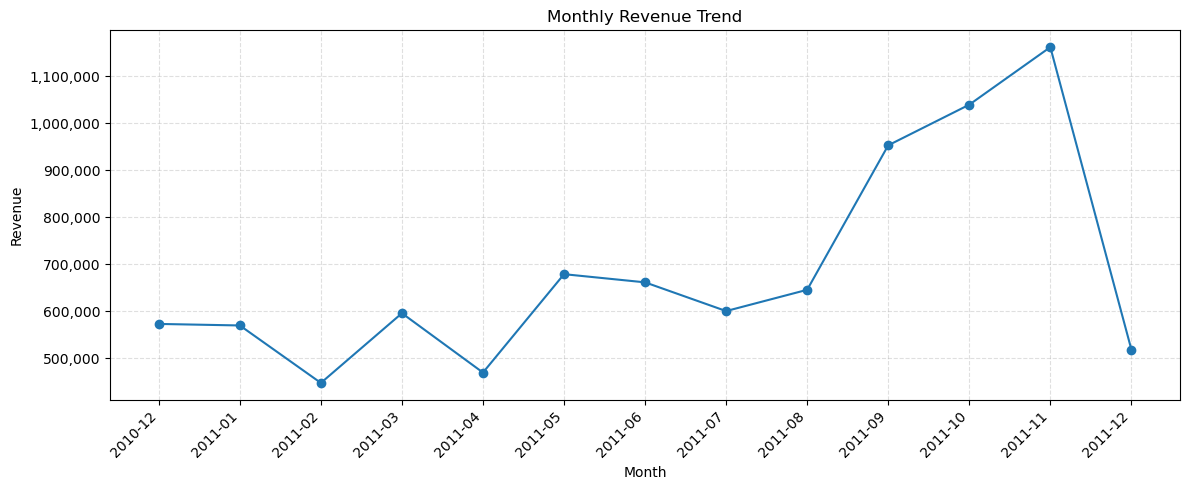

In [39]:
plt.figure(figsize=(12,5))
plt.plot(monthly_data["month"], monthly_data["revenue"], marker="o")
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")

plt.gca().yaxis.set_major_formatter(lambda x, _: f"{int(x):,}")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

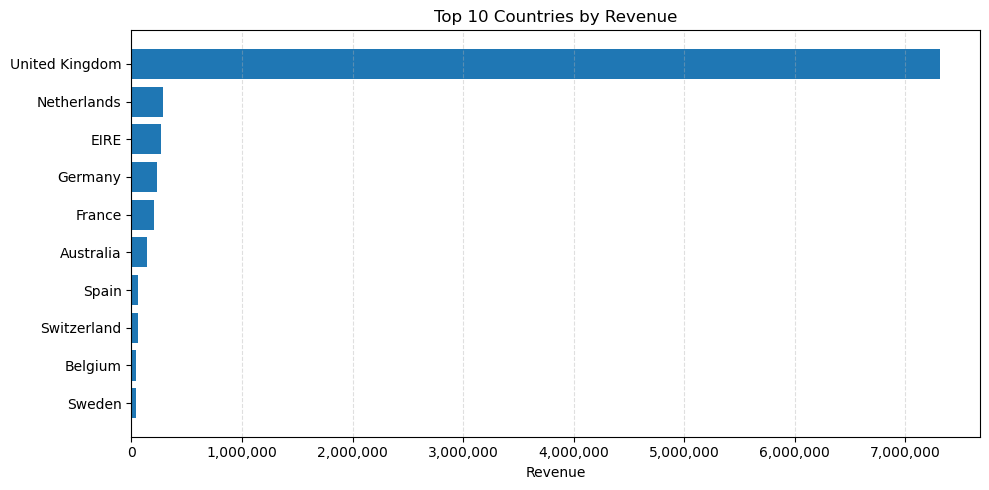

In [40]:
plt.figure(figsize=(10,5))
plt.barh(country_data["Country"], country_data["revenue"])
plt.gca().invert_yaxis()
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Revenue")
plt.gca().xaxis.set_major_formatter(lambda x, _: f"{int(x):,}")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()

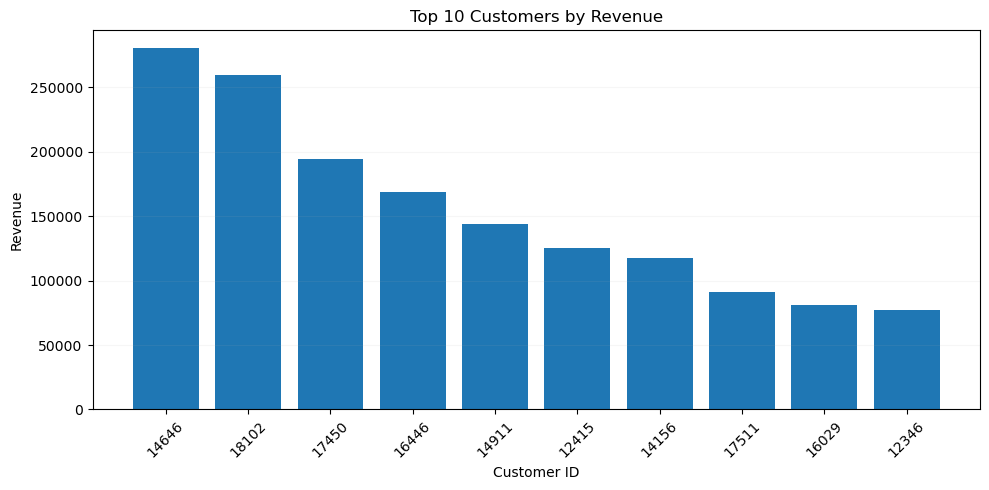

In [41]:
plt.figure(figsize=(10,5))
plt.bar(customer_data["CustomerID"].astype(str), customer_data["revenue"])
plt.title("Top 10 Customers by Revenue")
plt.xlabel("Customer ID")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()